# Hourly Energy Consumption Using LSTM

GROUP - 7

Anisha Siwas - 025007

Sarthak Jain - 025029

Tanya Goel - 025034

**Dataset Information** - PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

The dataset that we have used in this project is of Dominion Virginia Power.



**Importing all the required libraries.**

In [42]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential



**Loading data file.**

In [43]:
#choosing DOM_hourly.csv data for analysis
fpath="C:\\Users\\Anisha Siwas\\Downloads\\DOM_hourly.csv\\DOM_hourly.csv"

df=pd.read_csv(fpath)
df.head()


,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [44]:
df.dtypes

Datetime     object
DOM_MW      float64
dtype: object

**As Datetime feature is in object datatype, let's change it to date time datatype. As we are dealing with time series data, we need the datetime data to recognize a particular record.**

In [45]:
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


Checking for missing values.

In [46]:
df.isna().sum()

DOM_MW    0
dtype: int64

Since there is no missing data in the data loaded we will not be dropping the missing value records or will not be imputing the data. We will proceed with the further data analysis.

**Data Visualization before normalizing data.**

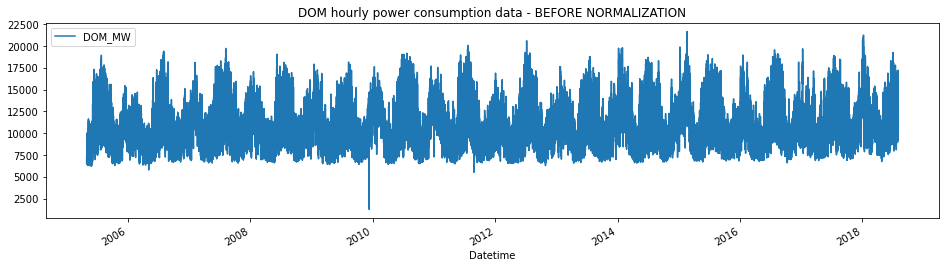

In [47]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

**Normalizing Data**

Before proceeding with further data analysis we must ensure that the data is normalized. For this we will be using sklearn MinMaxScaler.

In [48]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(116189, 1)

In [49]:
df.head

<bound method NDFrame.head of                        DOM_MW
Datetime                     
2005-12-31 01:00:00  0.398863
2005-12-31 02:00:00  0.383224
2005-12-31 03:00:00  0.379841
2005-12-31 04:00:00  0.381851
2005-12-31 05:00:00  0.386263
...                       ...
2018-01-01 20:00:00  0.841504
2018-01-01 21:00:00  0.848809
2018-01-01 22:00:00  0.836062
2018-01-01 23:00:00  0.811893
2018-01-02 00:00:00  0.792970

[116189 rows x 1 columns]>

**Data visulaization after normalizing data.**

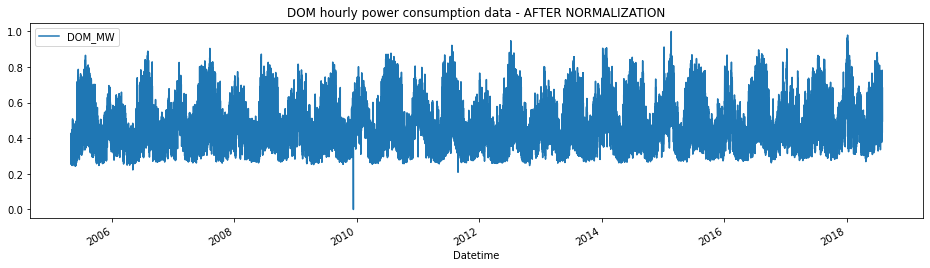

In [50]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

After normalization the range of power consumption values changes which we can observe on the y-axis of the graph. In the earlier graph that was displayed it was in the range 0 - 22500. Now after normalization we can observe that the data range on y-axis is 0.0 - 1.0

# Preparing data for training the RNN models

In [65]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[110000:]             
    y_test = y_train[110000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #Converting dataframe to an array as it allows for easier access of values in the dataframe. 
    #And also reduces memory consumption and makes it easier to work with large datasets.
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [54]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (110000, 20, 1)
y_train.shape =  (110000,)
X_test.shape =  (6169, 20, 1)
y_test.shape =  (6169,)


# Building a SIMPLE RNN model

In [55]:
# Initialising the RNN
rnn_model = Sequential()

#Adding input layer
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

#Adding output layer
rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 dropout (Dropout)           (None, 20, 40)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 40)            3240      
                                                                 
 dropout_1 (Dropout)         (None, 20, 40)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense (Dense)               (None, 1)                 4

In [56]:
#Compiling the RNN
rnn_model.compile(optimizer="adam",loss="MSE")

#Fitting the RNN to the training set
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 7s 48ms/step - loss: 0.0893
Epoch 2/10
110/110 [==============================] - 5s 48ms/step - loss: 0.0173
Epoch 3/10
110/110 [==============================] - 5s 48ms/step - loss: 0.0091
Epoch 4/10
110/110 [==============================] - 5s 48ms/step - loss: 0.0063
Epoch 5/10
110/110 [==============================] - 6s 51ms/step - loss: 0.0049
Epoch 6/10
110/110 [==============================] - 6s 51ms/step - loss: 0.0040
Epoch 7/10
110/110 [==============================] - 6s 53ms/step - loss: 0.0034
Epoch 8/10
110/110 [==============================] - 6s 56ms/step - loss: 0.0030
Epoch 9/10
110/110 [==============================] - 6s 56ms/step - loss: 0.0026
Epoch 10/10
110/110 [==============================] - 6s 55ms/step - loss: 0.0023


In [57]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

193/193 [==============================] - 1s 3ms/step
R2 Score of RNN model =  0.9459781358662257


Let's compare the actual values vs predicted values by plotting a graph.

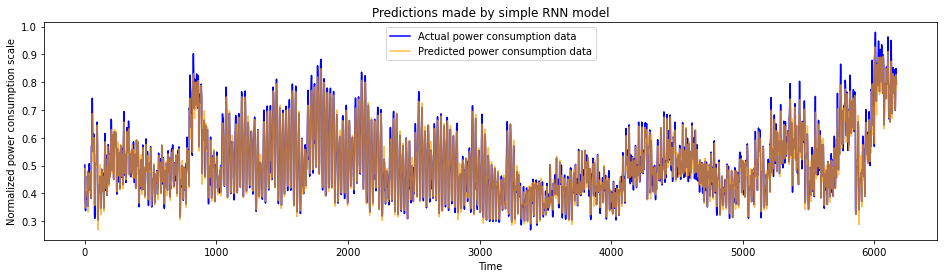

In [58]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

We see that the predicted values are close to the actual values meaning the RNN model is performing well in predicting the sequence.

# Building an LSTM model

In [59]:
#Initializing the LSTM 
lstm_model = Sequential()

#Adding input layer
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

#Adding output layer
lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 40)            6720      
                                                                 
 dropout_3 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 40)            12960     
                                                                 
 dropout_4 (Dropout)         (None, 20, 40)            0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [60]:
#Compiling the LSTM
lstm_model.compile(optimizer="adam",loss="MSE")

#Fitting the LSTM to the training set
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
110/110 [==============================] - 17s 126ms/step - loss: 0.0230
Epoch 2/10
110/110 [==============================] - 15s 133ms/step - loss: 0.0113
Epoch 3/10
110/110 [==============================] - 15s 135ms/step - loss: 0.0059
Epoch 4/10
110/110 [==============================] - 15s 139ms/step - loss: 0.0042
Epoch 5/10
110/110 [==============================] - 15s 141ms/step - loss: 0.0032
Epoch 6/10
110/110 [==============================] - 16s 144ms/step - loss: 0.0025
Epoch 7/10
110/110 [==============================] - 17s 154ms/step - loss: 0.0021
Epoch 8/10
110/110 [==============================] - 18s 164ms/step - loss: 0.0019
Epoch 9/10
110/110 [==============================] - 17s 159ms/step - loss: 0.0018
Epoch 10/10
110/110 [==============================] - 18s 162ms/step - loss: 0.0017


In [61]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

193/193 [==============================] - 2s 6ms/step
R^2 Score of LSTM model =  0.9567652597161511


Let's compare the actual values vs predicted values by plotting a graph

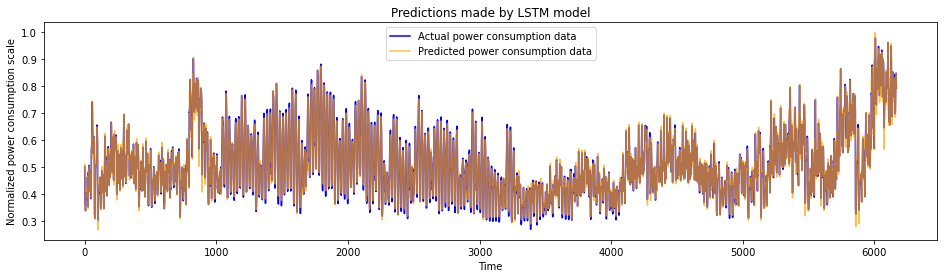

In [62]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

R^2 score for simple RNN model is 0.945 and for LSTM model is 0.956. As best possible R^2 score is 1.0 which is considered as best prediction and a score of 0.0 is considered as imperfect prediction therefore, it can be concluded that R^2 score of LSTM model is slightly better than that of simple RNN model.

#  Comparing predictions made by simple RNN, LSTM model by plotting data in a single graph

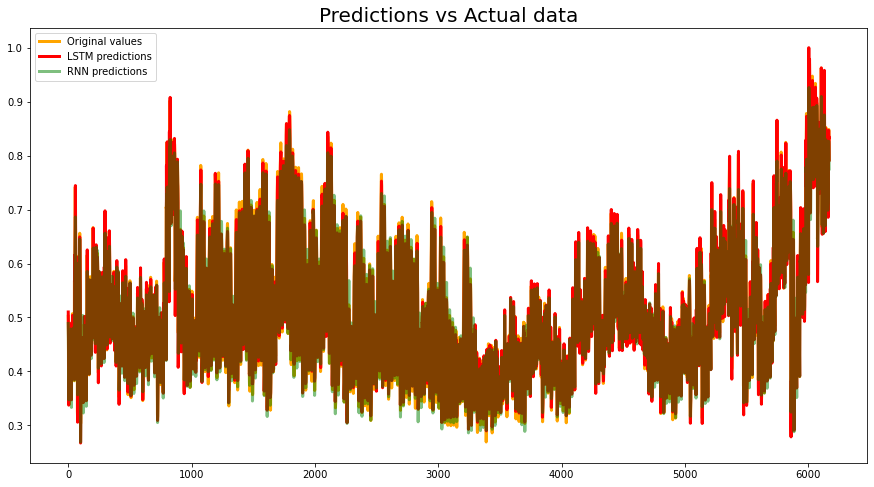

In [64]:
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="red", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="green", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs Actual data", fontsize=20)
plt.show()